In [1]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition

fm = FailureMode(alpha=50, beta=1.5, gamma=10)

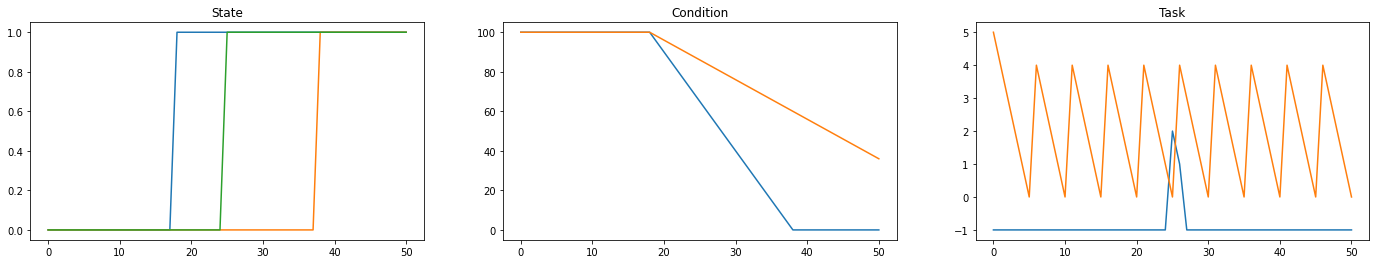

In [3]:
timeline = fm.sim_timeline(50, 0)
fm.plot_timeline()

In [13]:

timeline = fm.sim_timeline(t_start=t_now, t_end=t_end)

while t_now < t_end:
    print('sim %s ' %(t_now))

    # Check when the next task needs to be executed
    t_now, task_names = fm.next_tasks(timeline, t_now, t_end)

    for task_name in task_names:
        
        # Execute the task
        print('execute %s' %(task_name))
        states = fm.tasks[task_name].sim_completion(t_end = t_end, timeline=timeline, states = fm.get_states(), conditions = fm.conditions)
        
        fm.set_states(states)
    
    t_now = t_now + 1


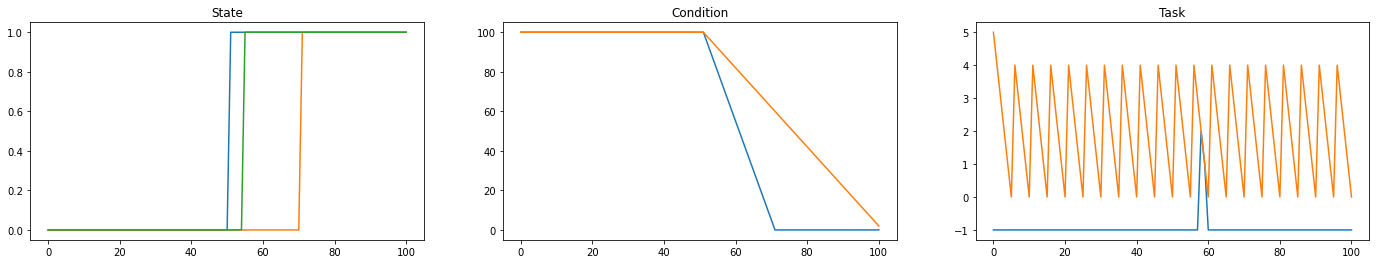

In [5]:
fm.plot_timeline()

In [20]:
t_start=t_now
t_end=t_end
states_to_update=states
conditions_to_update = dict()

# Check for initiation changes
if 'intiation' in states_to_update:
    timeline['initiation'][t_start:t_end] = np.full(t_end - t_start + 1, states_to_update['initiation'])
    t_initiate = t_start
    if states_to_update['initiation'] == False:
        t_initiate = min(t_end, int(fm.init_dist.sample()))
        timeline['initiation'][t_initiate:] = 1

# Check for condition changes
for condition in fm.conditions.values():
    if condition.name in conditions_to_update:
        timeline[condition.name][t_start:t_end] = condition.get_condition_profile(t_start=-t_initiate, t_stop=t_end - t_initiate)

# Check for detection changes
if 'detection' in states_to_update:
    timeline['detection'][t_start:t_end] = np.full(t_end - t_start + 1, states_to_update['detection'])

# Check for failure changes
if 'failure' in states_to_update:
    timeline['failure'] = np.full(t_end - t_start + 1, states_to_update['failed'])
    if states_to_update['failed'] == False:
        for condition in fm.conditions.values():
            tl_f = condition.sim_failure_timeline(t_start = - t_initiate, t_stop = t_end - t_initiate)
            timeline['failure'] = (timeline['failure']) | (tl_f)

ValueError: could not broadcast input array from shape (96) into shape (95)

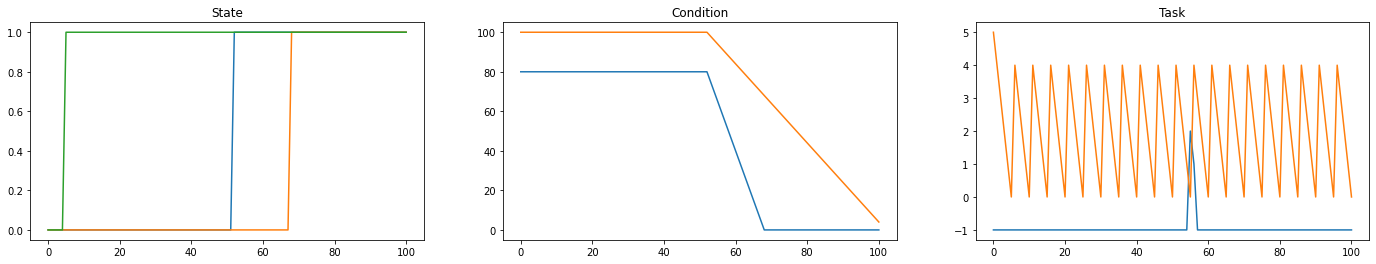

In [21]:
fm.conditions['wall_thickness'].set_condition(80)
fm.conditions['wall_thickness'].set_condition_profile()
fm.sim_timeline(100)
fm.plot_timeline()

In [ ]:
abc = fm.tasks['ocr'].sim_timeline(timeline=fm.sim_timeline(50), t_end = 50)

In [ ]:
abc = (~abc).astype(int)

In [ ]:
fm.next_tasks(timeline, 50)

In [12]:
time = np.array(1)

In [14]:
time[10:30] = 'a'

IndexError: too many indices for array